We want to use (train) a Gaussian Process for regression analysis so that we can determin (by fitting) 

In [1]:
using CSV
using DataFrames
using PyPlot
using StatsBase #Statistics
using Formatting # string formatting
using ScikitLearn # machine learning package
using ScikitLearn.CrossValidation: train_test_split
@sk_import gaussian_process : GaussianProcessRegressor
@sk_import gaussian_process.kernels : Matern

@sk_import inspection : permutation_importance
# @sk_import metrics : confusion_matrix

PyObject <function permutation_importance at 0x7fe8e7463790>

In [2]:
filename = joinpath(pwd(), "descriptors/cof_descriptors.csv")
descriptors = CSV.read(filename, DataFrame)
rename!(descriptors, "crystal_name" => "xtal")

,xtal,pore_diameter_Å,void_fraction,surface_area_m²g⁻¹,crystal_density
,String,Float64,Float64,Float64,Float64
1,05000N2_ddec.cif,3.84928,0.2,4175.64,1049.37
2,05001N2_ddec.cif,19.7302,0.6,3156.96,585.477
3,07000N2_ddec.cif,26.1625,0.8,3407.23,458.054
4,07001N2_ddec.cif,7.82083,0.4,2565.59,1100.22
5,07002N2_ddec.cif,14.8469,0.4,3345.75,703.114
6,07010N3_ddec.cif,9.33026,0.7,5261.66,421.68
7,07011N3_ddec.cif,9.94867,0.7,5452.36,383.117
8,07012N3_ddec.cif,18.946,0.9,5335.37,180.981
9,07013N3_ddec.cif,27.193,0.9,5190.06,171.075


In [3]:
# for some reason these ones aren't working...
# "14040N2_ddec.cif" OUT_OF_MEMORY error from slurm
# NOTE: second row has "⟨N⟩ (mmol/g)" = [0.0, 0.0] producing sel = NaN... need to run gcmc on these?
skip_for_now = ["14040N2_ddec.cif",  
                "13030N2_ddec.cif", "16371N2_ddec.cif", "20565N3_ddec.cif", "21090N3_ddec.cif"] # "07012N3_ddec.cif", "21111N3_ddec.cif", "16290N3_ddec.cif",

filter!(row -> ! (row["xtal"] in skip_for_now), descriptors);

In [4]:
# # for some reason these ones aren't working... LOOk INTO IT
# # NOTE: second row has "⟨N⟩ (mmol/g)" = [0.0, 0.0] producing sel = NaN... need to run gcmc on these?
# skip_for_now = ["07012N3_ddec.cif", "14040N2_ddec.cif",  "21111N3_ddec.cif",
#                 "13030N2_ddec.cif", "16371N2_ddec.cif", "20565N3_ddec.cif", "21090N3_ddec.cif"] #"16290N3_ddec.cif",

# filter!(row -> ! (row[:xtal] in skip_for_now), descriptors)

In [5]:
target_data = CSV.read(joinpath(pwd(), "target_and_cost_data.csv"), DataFrame)

target_data[1:5, :]

,xtal,henry_selectivity,gcmc_selectivity
,String,Float64,Float64
1,05000N2_ddec.cif,1.58051,1.69624
2,05001N2_ddec.cif,3.27135,3.2725
3,07000N2_ddec.cif,2.9979,2.99372
4,07001N2_ddec.cif,9.01379,9.65039
5,07002N2_ddec.cif,3.60253,3.64401


In [6]:
names(target_data)

3-element Vector{String}:
 "xtal"
 "henry_selectivity"
 "gcmc_selectivity"

Scikitlearn takes as input:

- a feature matrix X, which must be n_samples by n_features
- a target vector y, which must be n_samples long (of course)

In [7]:
x_cols = [name for name in names(descriptors) if name != "xtal"]
n_xtals = nrow(descriptors)

X = zeros(n_xtals, length(x_cols))
henry_y = zeros(n_xtals)
gcmc_y  = zeros(n_xtals)

for (i, row) in enumerate(eachrow(descriptors))   
    for (j, col_name) in enumerate(x_cols)
        X[i, j] = row[col_name]
    end
    # Xe/Kr Selectivity
    henry_y[i] = target_data[i, :henry_selectivity] 
    gcmc_y[i]  = target_data[i, :gcmc_selectivity]
end
X # look at y too!

607×14 Matrix{Float64}:
  3.84928  0.2  4175.64  1049.37   0.0292303   …  0.00974344   0.0  0.0  0.0
 19.7302   0.6  3156.96   585.477  0.0204808      0.00227564   0.0  0.0  0.0
 26.1625   0.8  3407.23   458.054  0.0171524      0.00142936   0.0  0.0  0.0
  7.82083  0.4  2565.59  1100.22   0.037349       0.00466863   0.0  0.0  0.0
 14.8469   0.4  3345.75   703.114  0.0271906      0.00194218   0.0  0.0  0.0
  9.33026  0.7  5261.66   421.68   0.0149858   …  0.00239773   0.0  0.0  0.0
  9.94867  0.7  5452.36   383.117  0.0125929      0.00209882   0.0  0.0  0.0
 18.946    0.9  5335.37   180.981  0.00653913     0.000544927  0.0  0.0  0.0
 27.193    0.9  5190.06   171.075  0.00643935     0.000525661  0.0  0.0  0.0
 10.0414   0.6  5593.85   519.979  0.0156241      0.00175223   0.0  0.0  0.0
  4.7838   0.2  3845.42  1143.15   0.0374755   …  0.00468444   0.0  0.0  0.0
  7.51918  0.4  3597.55   988.327  0.0313415      0.00447735   0.0  0.0  0.0
  9.8332   0.5  3440.67   874.7    0.0265802      0.

In [8]:
for j in 1:length(x_cols)
    X[:, j] = (X[:, j] .- minimum(X[:, j])) / (maximum(X[:, j]) - minimum(X[:, j]))
end
println(minimum(X[:, 2]))
println(maximum(X[:, 2]))

0.0
1.0


In [9]:
###
#  Spit data into training and testing sets
###
henry_X_train, henry_X_test, henry_y_train, henry_y_test = train_test_split(X, henry_y, test_size=0.4)
gcmc_X_train, gcmc_X_test, gcmc_y_train, gcmc_y_test = train_test_split(X, gcmc_y, test_size=0.4)

###
#  Construct GP 
###
henry_kernel = Matern(nu=2.5, length_scale=0.25) 
henry_gpr = GaussianProcessRegressor(kernel=henry_kernel, normalize_y=true, n_restarts_optimizer=5)

gcmc_kernel = Matern(nu=2.5, length_scale=0.25) 
gcmc_gpr  = GaussianProcessRegressor(kernel=gcmc_kernel, normalize_y=true, n_restarts_optimizer=5)

PyObject GaussianProcessRegressor(kernel=Matern(length_scale=0.25, nu=2.5),
                         n_restarts_optimizer=5, normalize_y=True)

In [10]:
###
#  Train GP on data 
###
henry_gpr.fit(henry_X_train, henry_y_train)
gcmc_gpr.fit(gcmc_X_train, gcmc_y_train)

PyObject GaussianProcessRegressor(kernel=Matern(length_scale=0.25, nu=2.5),
                         n_restarts_optimizer=5, normalize_y=True)

In [11]:
henry_gpr.kernel_

PyObject Matern(length_scale=0.233, nu=2.5)

In [12]:
gcmc_gpr.kernel_

PyObject Matern(length_scale=0.209, nu=2.5)

In [13]:
###
#  predictions on test data using trained GP
###
henry_y_pred = henry_gpr.predict(henry_X_test)
gcmc_y_pred = gcmc_gpr.predict(gcmc_X_test)

243-element Vector{Float64}:
 6.410931905478878
 3.4449673275191577
 3.150492507413451
 5.252603118913218
 9.952188804284601
 3.236987130861335
 3.6382619013322435
 2.555971556143996
 3.718234804421087
 3.6637531086432436
 2.966954777216488
 4.505783762985672
 3.1952094895665795
 ⋮
 4.09916775355824
 2.7931811627807672
 4.258657581596485
 9.029354326677622
 3.982863844036406
 3.299246658118408
 2.8887798965083276
 4.570158945523226
 2.5081850519870272
 3.156625615326783
 4.648176338360687
 3.6272069858158824

In [14]:
###
#  Compute statistics about the fit
###
# compute RMSE, R2 on test data
henry_rmse = sqrt(mean((henry_y_test - henry_y_pred).^2))
henry_r2 = henry_gpr.score(henry_X_test, henry_y_test)
henry_corspearman = corspearman(henry_y_test, henry_y_pred)

# permutation importance (of input features)
# henry_feature_importances = permutation_importance(henry_gpr, henry_X_test, henry_y_test)

0.7064886319729837

In [15]:
gcmc_rmse = sqrt(mean((gcmc_y_test - gcmc_y_pred).^2))
gcmc_r2 = gcmc_gpr.score(gcmc_X_test, gcmc_y_test)
gcmc_corspearman = corspearman(gcmc_y_test, gcmc_y_pred)

# gcmc_feature_importances  = permutation_importance(gcmc_gpr, gcmc_X_test, gcmc_y_test)

0.697468976902658

## Parity Plot

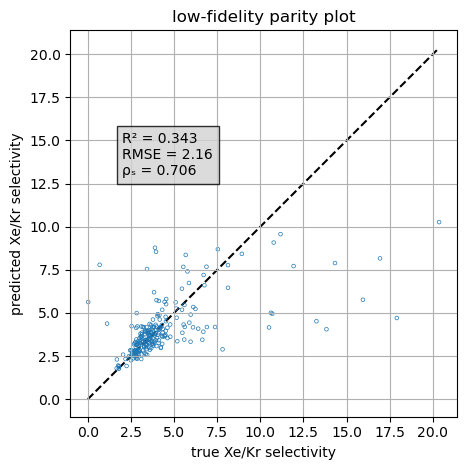

In [16]:
figure()

xmax = maximum(max.(henry_y_test, henry_y_pred))
x = range(0.0, stop=xmax, length=length(henry_y_test))
y = x
plot(x, y, color="k", linestyle="--", zorder=0)

scatter(henry_y_test, henry_y_pred, facecolor="none", edgecolor="C0", linewidth=0.5, s=7)

str = format("R² = {:0.3f}\nRMSE = {:0.2f}\nρₛ = {:0.3f}", henry_r2, henry_rmse, henry_corspearman)
box_styl = Dict(:facecolor => "lightgrey", :alpha => 0.8)
text(2, 13, str, color="k", bbox=box_styl)

grid("on")
gca().set_aspect("equal", adjustable="box")

title("low-fidelity parity plot")
xlabel("true Xe/Kr selectivity")
ylabel("predicted Xe/Kr selectivity")

tight_layout()
# savefig(joinpath(pwd(), "henry_selectivity_parity_plot.png"), dpi=600, format="png")

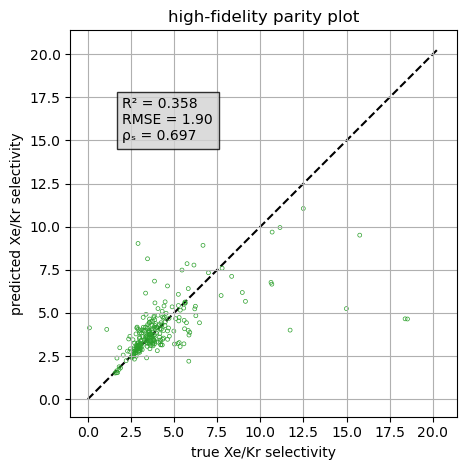

In [17]:
fig = figure()

xmin = minimum(min.(gcmc_y_test, gcmc_y_pred))
# xmax = maximum(max.(gcmc_y_test, gcmc_y_pred))
x = range(0.0, stop=xmax, length=length(gcmc_y_test))
y = x
plot(x, y, color="k", linestyle="--", zorder=0)

scatter(gcmc_y_test, gcmc_y_pred, facecolor="none", edgecolor="C2", s=8, linewidth=0.5)

str = format("R² = {:0.3f}\nRMSE = {:0.2f}\nρₛ = {:0.3f}", gcmc_r2, gcmc_rmse, gcmc_corspearman)
box_styl = Dict(:facecolor => "lightgrey", :alpha => 0.8)
plt = text(2, 15, str, color="k", bbox=box_styl)


grid("on")
gca().set_aspect("equal", adjustable="box")

title("high-fidelity parity plot")
xlabel("true Xe/Kr selectivity")
ylabel("predicted Xe/Kr selectivity")

tight_layout()
# savefig(joinpath(pwd(), "gcmc_selectivity_parity_plot.png"), dpi=600, format="png")